<a href="https://colab.research.google.com/github/aiAdrian/flatland_railway_extension/blob/master/Flatland_Dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🚂 The Flatland Dynamics Demo

Flatland Extension code base:
https://github.com/aiAdrian/flatland_railway_extension/blob/master/flatland_extensions/environment_extensions
 

In [1]:
from IPython.display import clear_output 
clear_output()

In [2]:
!git clone http://gitlab.aicrowd.com/flatland/flatland.git
%cd flatland
!git pull
%cd ..
!pip install -r /content/flatland/requirements_dev.txt &> /dev/null

Cloning into 'flatland'...
remote: Enumerating objects: 17135, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 17135 (delta 59), reused 69 (delta 38), pack-reused 17032
Receiving objects: 100% (17135/17135), 53.27 MiB | 7.51 MiB/s, done.
Resolving deltas: 100% (12853/12853), done.
/content/flatland
Already up to date.
/content


In [3]:
!git clone https://github.com/aiAdrian/flatland_railway_extension.git/
%cd flatland_railway_extension
!git pull
%cd ..

Cloning into 'flatland_railway_extension'...
remote: Enumerating objects: 2376, done.
remote: Counting objects: 100% (402/402), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 2376 (delta 253), reused 385 (delta 243), pack-reused 1974
Receiving objects: 100% (2376/2376), 26.15 MiB | 19.88 MiB/s, done.
Resolving deltas: 100% (1525/1525), done.
/content/flatland_railway_extension
Already up to date.
/content


In [4]:
import os
import sys
os.environ['PYTHONPATH'] = "/env/python:/content/flatland:/content/flatland_railway_extension"
if "/content/flatland" not in sys.path:
  sys.path.insert(1, "/content/flatland")
if "/content/flatland_railway_extension" not in sys.path:
  sys.path.insert(1, "/content/flatland_railway_extension")

In [5]:
# import all flatland dependance
import time

from flatland.utils.rendertools import RenderTool
from flatland.envs.rail_env_action import RailEnvActions

import numpy as np
from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_env_action import RailEnvActions

from flatland_railway_extension.FlatlandEnvironmentHelper import FlatlandEnvironmentHelper
from flatland_railway_extension.RailroadSwitchAnalyser import RailroadSwitchAnalyser
from flatland_railway_extension.RailroadSwitchCluster import RailroadSwitchCluster
from flatland_railway_extension.environments.FlatlandDynamics import FlatlandDynamics
from flatland_railway_extension.environments.FlatlandResourceAllocator import FlatlandResourceAllocator
from flatland_railway_extension.environments.InfrastructureData import InfrastructureData
from flatland_railway_extension.utils.FlatlandDynamicsRenderer import FlatlandDynamicsRenderer
from flatland_railway_extension.environments.DynamicAgent import DynamicAgent

In [6]:
from IPython.display import HTML, display, clear_output
import ipywidgets as ipw
from io import BytesIO
import PIL
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import time      
  
def create_rendering_area():
  rendering_area = ipw.Image()
  display(rendering_area)
  return rendering_area

def render_env_to_image(flatland_renderer):
  flatland_renderer.render(show=False, show_observations=True, disable_background_rendering=True)
  image = flatland_renderer.env_renderer.get_image()
  return image

def render_env(flatland_renderer, rendering_area : ipw.Image):
  pil_image = PIL.Image.fromarray(render_env_to_image(flatland_renderer))
  if rendering_area is None:
    clear_output(wait=False)
    display(pil_image)
    return

  # convert numpy to PIL to png-format bytes  
  with BytesIO() as fOut:
    pil_image.save(fOut, format="png")
    byPng = fOut.getvalue()
      
  # set the png bytes as the image value; 
  # this updates the image in the browser.
  rendering_area.value=byPng

def process_frames(frames):
  dpi = 72
  interval = 1000/60 # ms

  plt.figure(figsize=(frames[0].shape[1]/dpi,frames[0].shape[0]/dpi),dpi=dpi)
  plt.axis=('off')
  plot = plt.imshow(frames[0])

  def init():
    pass

  def update(i):
    plot.set_data(frames[i])
    return plot,

  anim = FuncAnimation(fig=plt.gcf(),
                      func=update,
                      frames=len(frames),
                      init_func=init,
                      interval=interval,
                      repeat=True,
                      repeat_delay=20)
  plt.close(anim._fig)
  return anim


In [7]:
def create_infrastructure_data(env: RailEnv, railroad_switch_analyser : RailroadSwitchAnalyser) -> InfrastructureData:
    infrastructure_data = InfrastructureData()
    cell_length_grid = np.ones((env.height, env.width)) * 400
    gradient_grid = np.zeros((env.height, env.width))
    velocity_grid = np.ones((env.height, env.width)) * 100
    for key in railroad_switch_analyser.railroad_switch_neighbours.keys():
        velocity_grid[key] = 80
    for key in railroad_switch_analyser.railroad_switches.keys():
        velocity_grid[key] = 60
    infrastructure_data.set_infrastructure_max_velocity_grid(velocity_grid / 3.6)
    infrastructure_data.set_infrastructure_cell_length_grid(cell_length_grid)
    infrastructure_data.set_infrastructure_gradient_grid(gradient_grid)
    return infrastructure_data

In [8]:
def map_infrastructure_data(env: RailEnv, railroad_switch_analyser: RailroadSwitchAnalyser):
    # Create a test infrastructure
    # ---------------------------------------------------------------------------------------------------------------
    # share the infrastructure with the agents ( train runs)
    for agent in env.agents:
        if isinstance(agent, DynamicAgent):
            agent.set_infrastructure_data(
                create_infrastructure_data(env, railroad_switch_analyser)
            )
            agent.rolling_stock.set_max_braking_acceleration(-0.15)
            agent.set_mass(500)
            agent.set_tractive_effort_rendering(False)
    if isinstance(env, FlatlandDynamics):
        env.set_infrastructure_data(create_infrastructure_data(env, railroad_switch_analyser))

In [9]:
def run_simulation(flatland_environment_helper, railroad_switch_cluster, railroad_switch_analyser):
  frames=[]
  env = flatland_environment_helper.get_rail_env()
  observations, info = env.reset()

  # create renderer
  rendering_area = create_rendering_area()
  flatland_renderer = FlatlandDynamicsRenderer(env=env,
                                              show_debug=True,
                                              show_agents=False)

  
  map_infrastructure_data(env=env,
                          railroad_switch_analyser=railroad_switch_analyser)

    
  flatland_resource_allocator = FlatlandResourceAllocator(env)
  flatland_resource_allocator.set_minimal_free_time_to_reallocate_other_agent(120)

  for step in range(1201):
      flatland_renderer.set_flatland_resource_allocator(flatland_resource_allocator)
      flatland_environment_helper.get_rail_env().activate_flatland_resource_allocator(flatland_resource_allocator)
      flatland_environment_helper.get_rail_env().activate_railroad_switch_cluster_locking(railroad_switch_cluster)

      actions = {}
      for agent_handle in flatland_environment_helper.get_rail_env().get_agent_handles():
          obs = observations[agent_handle]
          actions.update({agent_handle: RailEnvActions(obs[0])})

      observations, all_rewards, dones, info = env.step(actions)
      
      if step % 10 == 0 and step >0:
        render_env(flatland_renderer, rendering_area)
      frames.append(render_env_to_image(flatland_renderer))
 
      if dones["__all__"]:
          break  

  render_env(flatland_renderer, None)
  return frames

In [10]:
flatland_environment_helper = FlatlandEnvironmentHelper(rail_env=FlatlandDynamics, random_seed=2341)
railroad_switch_analyser = RailroadSwitchAnalyser(env=flatland_environment_helper.get_rail_env())
railroad_switch_cluster = RailroadSwitchCluster(railroad_switch_analyser=railroad_switch_analyser)

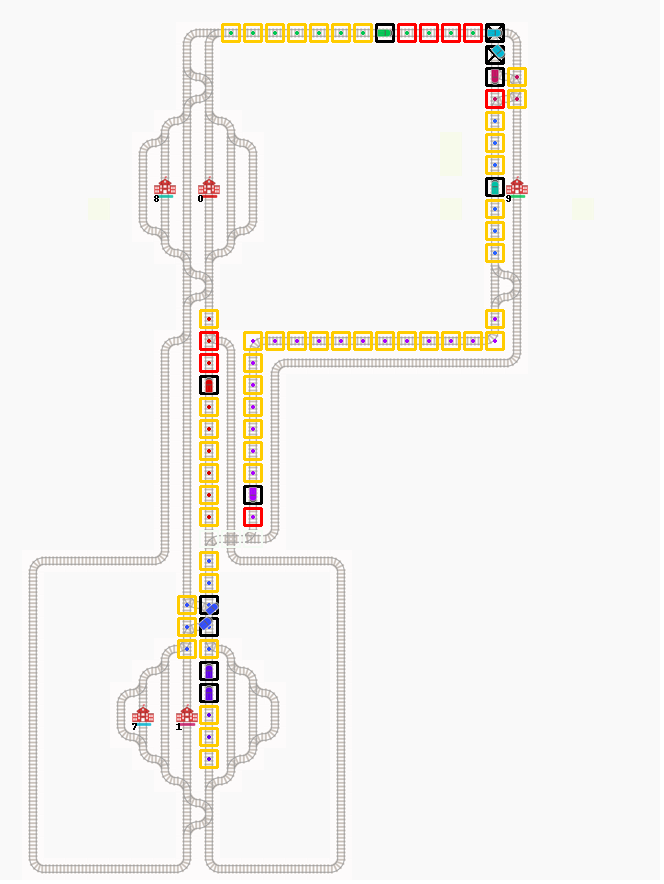

In [11]:
frames = run_simulation(flatland_environment_helper, railroad_switch_cluster, railroad_switch_analyser)

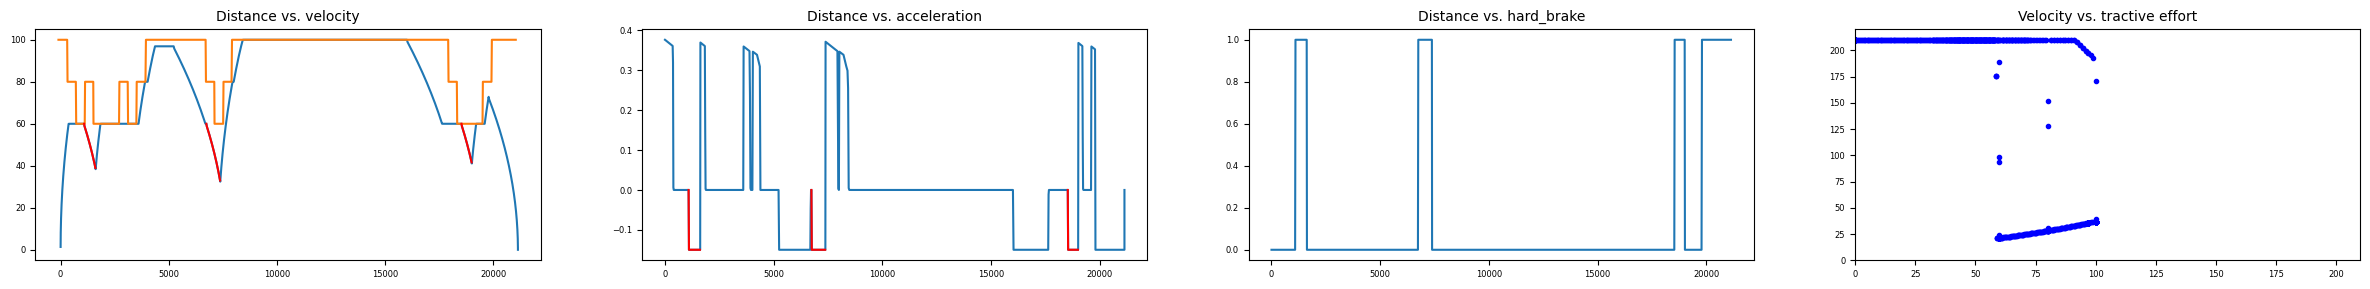

In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = [30, 3]
a3 = flatland_environment_helper.get_rail_env().agents[3]
a3.set_tractive_effort_rendering(True)
a3.do_debug_plot(1, 1, True)
a3.set_tractive_effort_rendering(False)

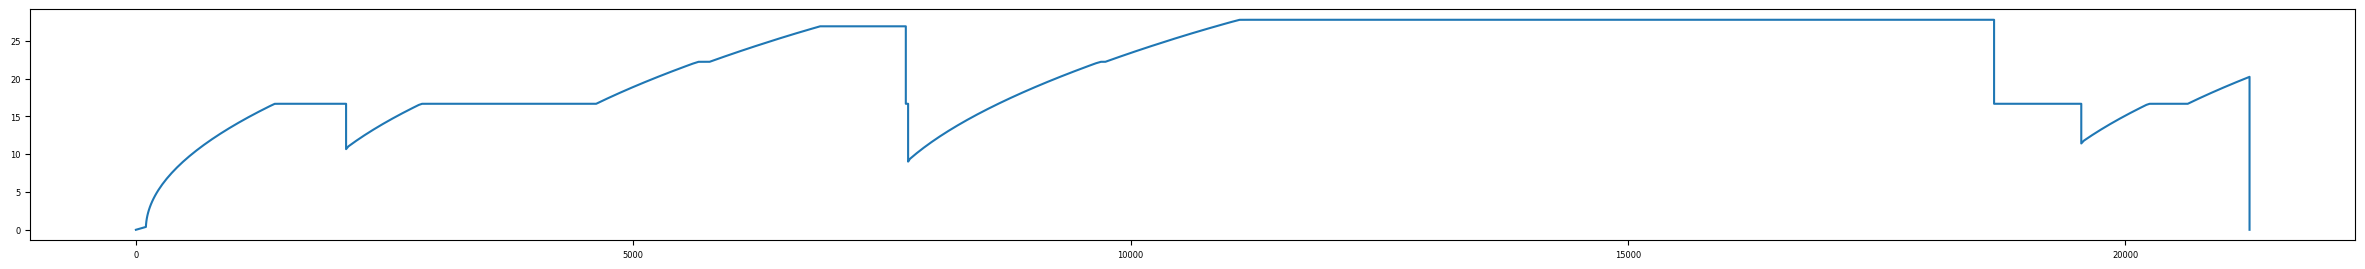

In [13]:
plt.plot(a3.distance_reservation_point_simulation_data, a3.velocity_agent_tp_simulation_data)

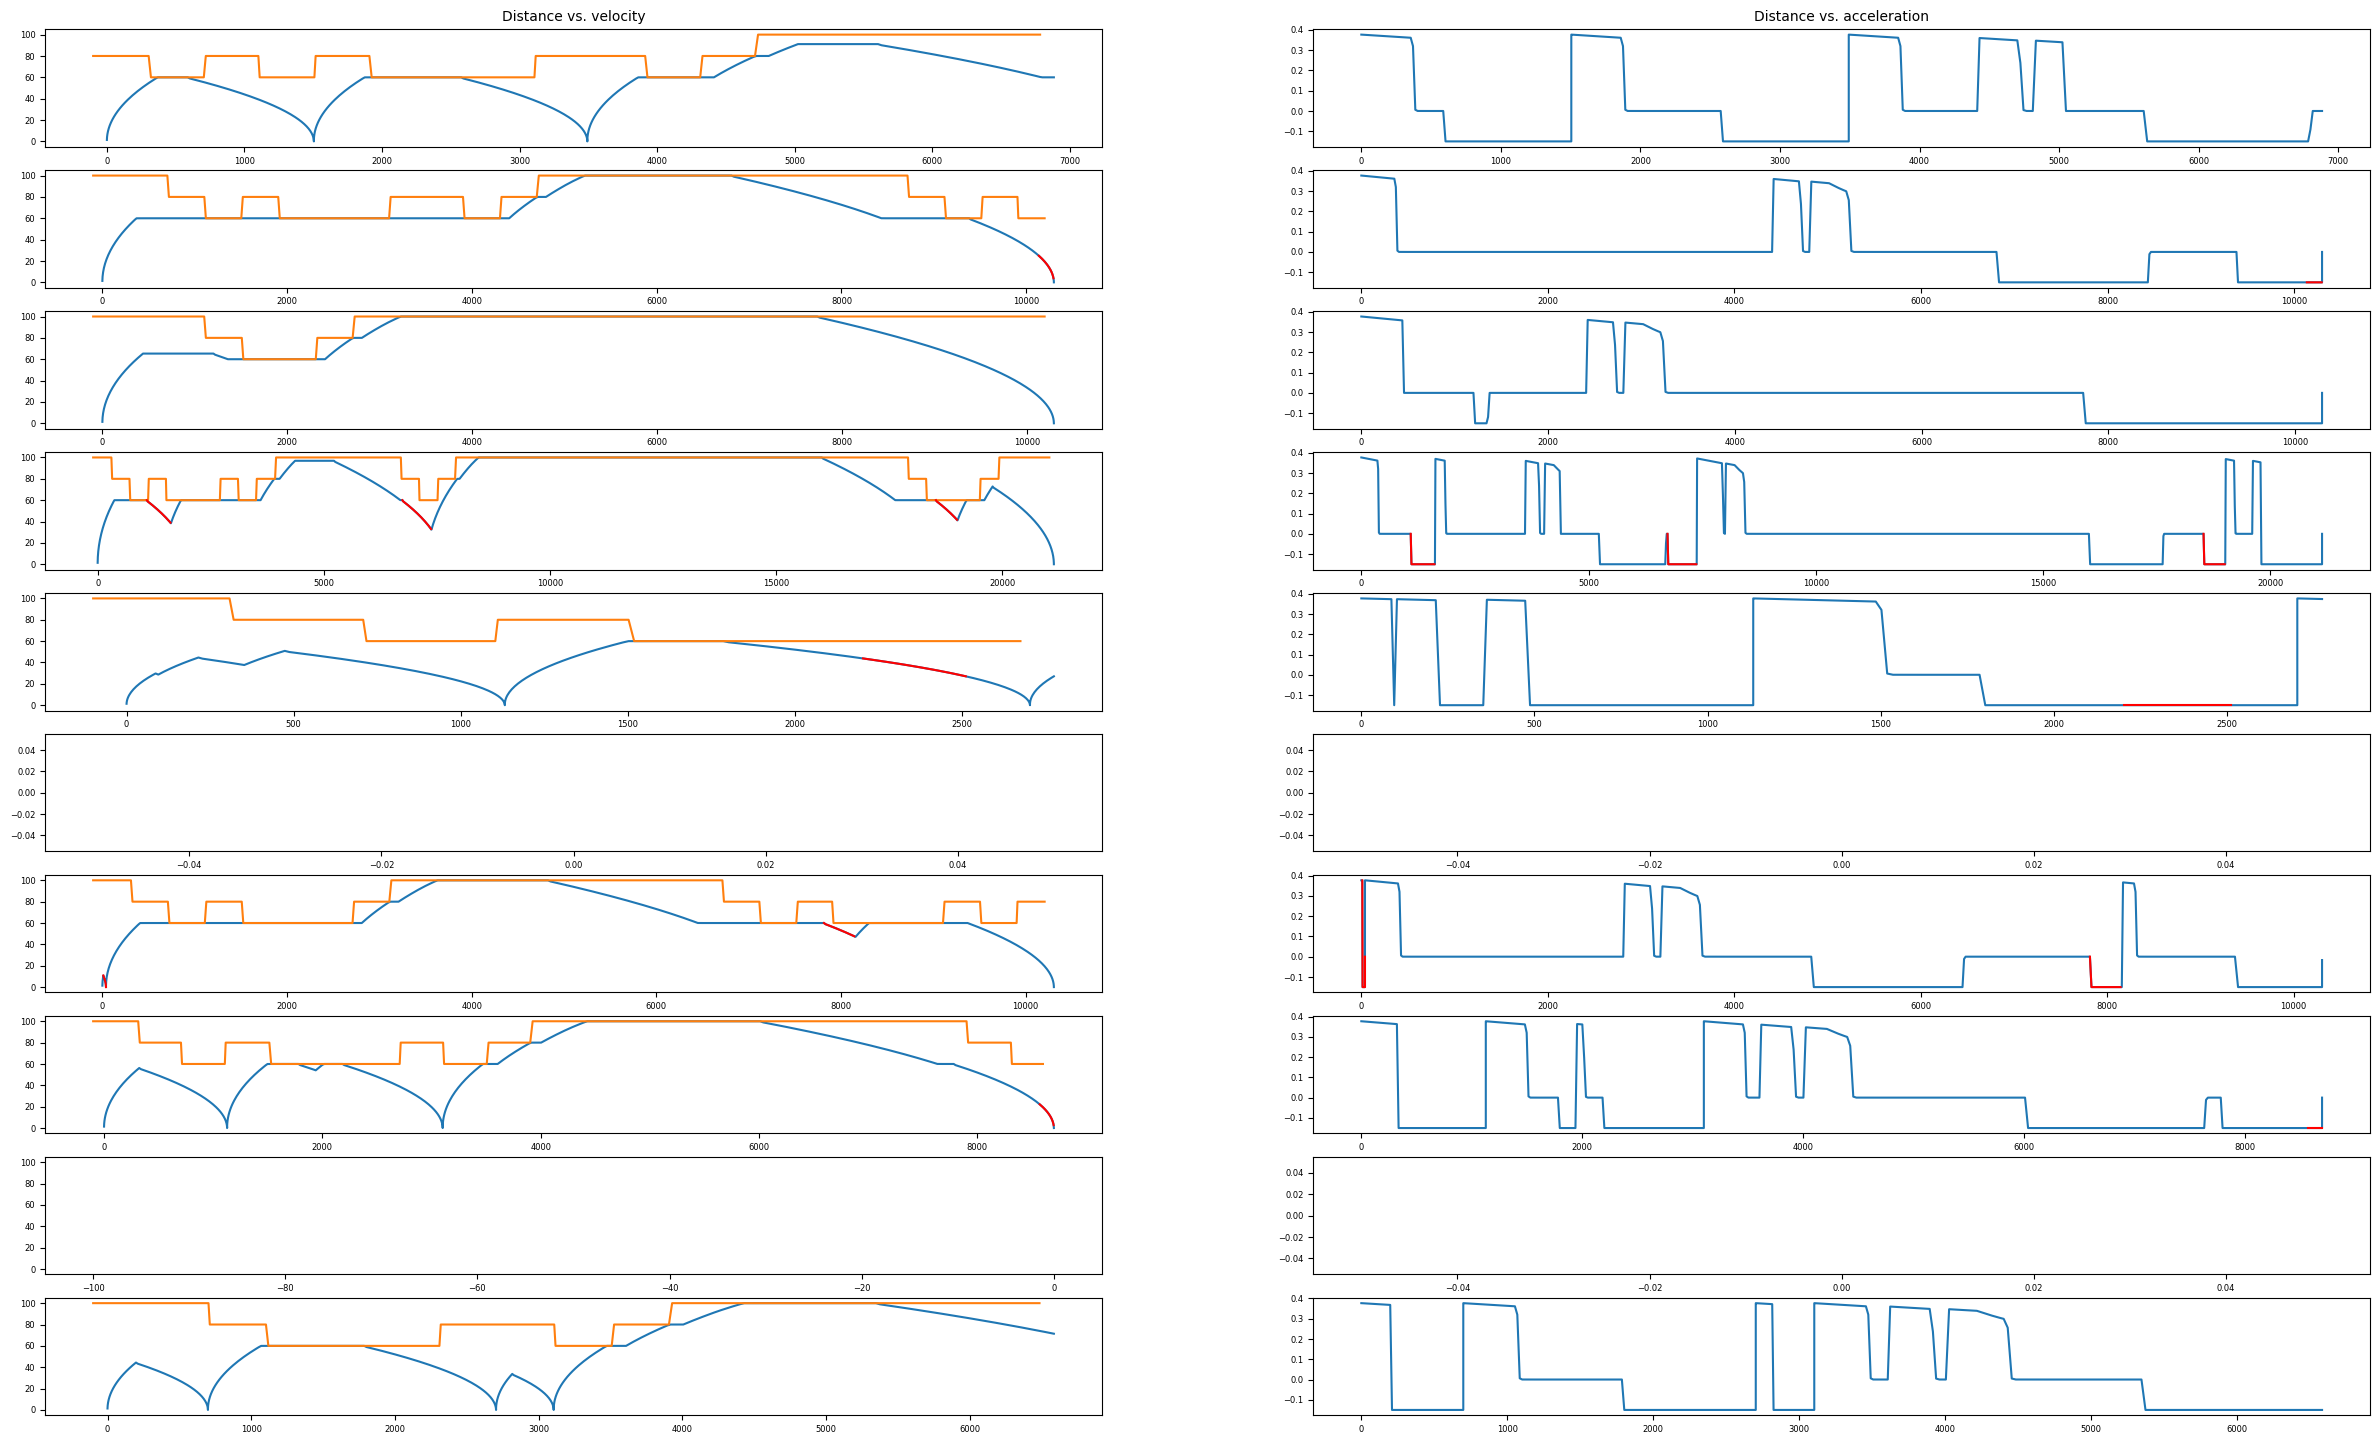

In [14]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = [30, 18]
for i_agent, agent in enumerate(flatland_environment_helper.get_rail_env().agents):
        n_agents = flatland_environment_helper.get_rail_env().get_num_agents()
        show = i_agent + 1 == n_agents
        agent.do_debug_plot(i_agent + 1, n_agents, show, i_agent==0)


In [15]:
anim = process_frames(frames)

In [16]:
from IPython.display import HTML
HTML(anim.to_html5_video())

Author: Adrian Egli